# 多層パーセプトロンの実装

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras
from sklearn.datasets import load_iris
from sklearn.metrics import f1_score

/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


/Users/yohei.moriya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: covariance is not symmetric positive-semidefinite.


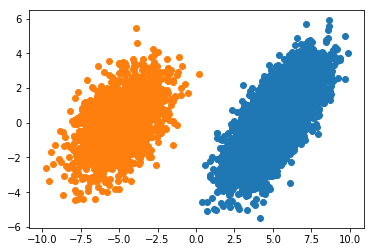

In [2]:
class CovarianceMatrix(pd.DataFrame):
    """
    共分散行列です。
    生成する際に自動で固有値・固有ベクトルを計算します。
    """
    
    @property
    def unique_val(self):
        """
        固有値のプロパティです。
        """
        return pd.DataFrame(self._cal_unique()[0])
    
    @property
    def unique_vec(self):
        """
        固有ベクトルのプロパティです。
        """
        return pd.DataFrame(self._cal_unique()[1])
    
    def _cal_unique(self):
        """
        固有値・固有ベクトルを計算します。
        
        """
        return np.linalg.eig(self.values)
    
    @staticmethod
    def compose(vec_var, vec_cov):
        """
        与えられた分散ベクトル・共分散ベクトルから、共分散行列を生成します。
        """
        return CovarianceMatrix([[vec_var[0]**2, vec_cov[0]], [vec_cov[0], vec_var[1] ** 2]])

    @staticmethod
    def genarate(nd_array: np.array):
        """
        与えられたデータから、共分散行列を生成します。
        """
        return CovarianceMatrix(np.cov(nd_array, rowvar=False))


class Nomal(pd.DataFrame):
    """
    正規分布です。
    """
    @staticmethod
    def create(vec_m, mat_cov, p, num):
        """
        平均ベクトルと共分散行列を指定して正規分布を生成します。

        :param vec_m 平均ベクトル
        :param mat_cov 共分散行列
        :param p 事前確率(生起確率)
        :param num データの個数
        """
        return Nomal(data=np.random.multivariate_normal(vec_m, mat_cov, round(p*num)))
    
    @property
    def mean(self):
        '''
        
        '''
        return self.values.mean(axis=0)
    
    @property
    def cov(self):
        '''
        
        '''
        return CovarianceMatrix.genarate(self)
    
    def concat(self, other):
        """
        他の分布と重ね合わせます。
        """
        return CovarianceMatrix(pd.concat([self, other]))


""" test """
num = 10000
cov = CovarianceMatrix([[1, 2], [2, 2]])
vec_mean = [5, 0]
p = 0.8
normal_c1 = Nomal.create(vec_m=vec_mean, mat_cov=cov, p=p, num=num)
plt.scatter(normal_c1.loc[:,0], normal_c1.loc[:,1])

cov = CovarianceMatrix([[1, 2], [2, 1]])
vec_mean = [-5, 0]
p = 0.2
normal_c2 = Nomal.create(vec_m=vec_mean, mat_cov=cov, p=p, num=num)
plt.scatter(normal_c2.loc[:,0], normal_c2.loc[:,1])
plt.show() 

In [3]:
def get_grid(xlim, ylim, num):
    """
    グリッドを生成します。
    """
    range_x = np.linspace(xlim[0], xlim[1], num)
    range_y = np.linspace(ylim[0], ylim[1], num)
    ranges = (range_x, range_y)
    nd_x = np.meshgrid(range_x, range_y)
    return ranges, np.array(nd_x).reshape(2, nd_x[0].size)

In [4]:
def init_model(input_dim, node_count, hidden_count):
    # モデルの作成
    model = Sequential()

    # モデルにレイヤーを積み上げていく
    # 　input
    model.add(Dense(units=node_count, input_dim=input_dim))
    model.add(Activation('relu'))

    #  hedden
    for index in range(hidden_count):
        model.add(Dense(units=node_count))
        model.add(Activation('relu'))

    # output
    model.add(Dense(units=1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
    
    return model

In [9]:
class Task():
    
    def __init__(self, df_train, df_label, node_count, hidden_count, epochs, batch_size):
        self.df_train = df_train
        self.df_label = df_label
        self.node_count = node_count
        self.hidden_count = hidden_count
        self.epochs = epochs
        self.batch_size = 10

    def run(self, ranges=None, verbose=1, is_dev=True):
        
        print(f"param : node={self.node_count}, hidden={self.hidden_count}")
        
        """ init model """
        input_dim = df_train.shape[1]
        clf = init_model(input_dim, self.node_count, self.hidden_count)
        
        """ train """
        history = clf.fit(
            x=self.df_train.values, 
            y=self.df_label.values, 
            epochs=self.epochs, 
            batch_size=self.batch_size, 
            verbose=verbose, 
            shuffle=True
        )

        """ show class line plot """
        fig = plt.figure()
        plt.figure(figsize=(8, 7))
        
        df_train_true = self.df_train[self.df_label == 1]
        df_train_false = self.df_train[self.df_label == 0]

        # show line
        maxs = self.df_train.max()
        mins = self.df_train.min()
        if ranges is None:
            ranges = [(mins[0], maxs[0]), (mins[1], maxs[1])]
        ranges, nd_plot_sample = get_grid(xlim=ranges[0], ylim=ranges[1], num=10)
        result = clf.predict(x=nd_plot_sample.T)
        surface = result.reshape(len(ranges[0]), len(ranges[1]))
        cont = plt.contour(ranges[0], ranges[1], surface, levels=[0.5])
        
        # show data
        plt.scatter(df_train_true.loc[:, 0], df_train_true.loc[:, 1], alpha=0.5)
        plt.scatter(df_train_false.loc[:, 0], df_train_false.loc[:, 1], alpha=0.5)
        plt.show()

        """ show learning process plot """
        if is_dev:
            plt.plot(history.history['acc'])
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()

            plt.plot(history.history['loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()

        """ score """
        score = clf.evaluate(df_train, df_label, verbose=0)
        print(f"Test score : {score[0]}")
        print(f"Test accuracy : {score[1]}")

param : node=5, hidden=5


<Figure size 432x288 with 0 Axes>

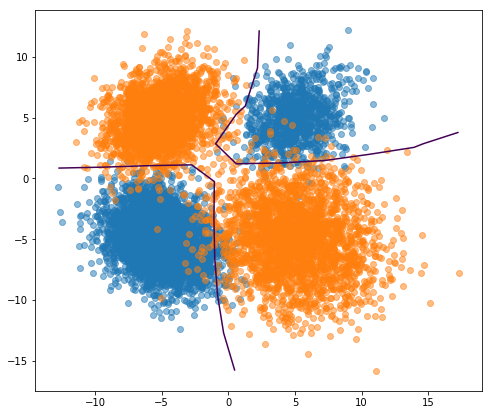

Test score : 0.06769591509113088
Test accuracy : 0.976
param : node=10, hidden=10


<Figure size 432x288 with 0 Axes>

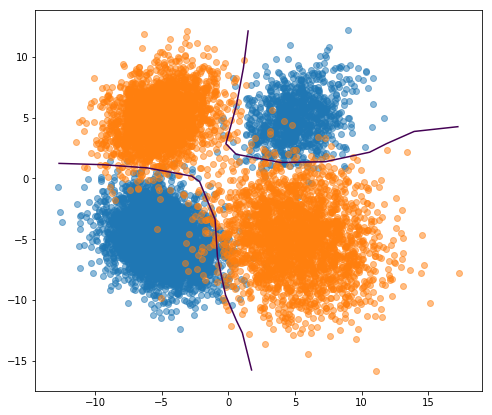

Test score : 0.06363794424701483
Test accuracy : 0.977
param : node=20, hidden=20


<Figure size 432x288 with 0 Axes>

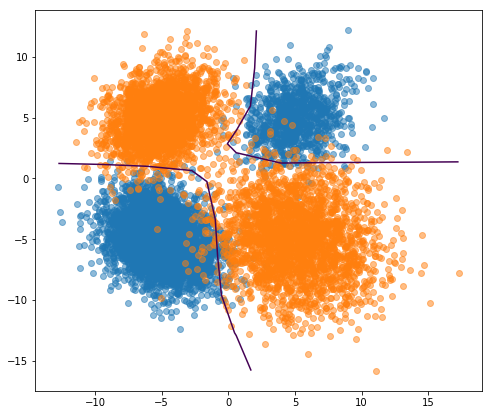

Test score : 0.06604061790099368
Test accuracy : 0.9773


In [10]:
""" create data """
num = 10000

mean1 = np.array([5, 5])
mean2 = np.array([-5, -5])
mean3 = np.array([-5, 5])
mean4 = np.array([5, -5])

cov1 = CovarianceMatrix.compose([2, 2], [1])
cov2 = CovarianceMatrix.compose([2, 2], [-1])
cov3 = CovarianceMatrix.compose([2, 2], [1])
cov4 = CovarianceMatrix.compose([3, 3], [-1])

p1 = [0.10, 0.40, 0.25, 0.25]

nomal1 = Nomal.create(vec_m=mean1, mat_cov=cov1, p=p1[0], num=num)
nomal2 = Nomal.create(vec_m=mean2, mat_cov=cov2, p=p1[1], num=num)
nomal3 = Nomal.create(vec_m=mean3, mat_cov=cov3, p=p1[2], num=num)
nomal4 = Nomal.create(vec_m=mean4, mat_cov=cov4, p=p1[3], num=num)

nomal_c1 = nomal1.concat(nomal2)
nomal_c2 = nomal3.concat(nomal4)

nomal_c1['target'] = 1
nomal_c2['target'] = 0

df_sample = pd.concat([nomal_c1, nomal_c2])

df_train = df_sample.drop('target', axis=1)
df_label = df_sample['target']

""" run task """
init_param1 = {
    "df_train" : df_train,
    "df_label" : df_label,
    "node_count" : 5, 
    "hidden_count" : 5, 
    "epochs" : 20, 
    "batch_size" : 10
}

init_param2 = {
    "df_train" : df_train,
    "df_label" : df_label,
    "node_count" : 10, 
    "hidden_count" : 10, 
    "epochs" : 20, 
    "batch_size" : 10
}

init_param3 = {
    "df_train" : df_train,
    "df_label" : df_label,
    "node_count" : 20, 
    "hidden_count" : 20, 
    "epochs" : 20, 
    "batch_size" : 10
}

Task(**init_param1).run(verbose=0, is_dev=False)
Task(**init_param2).run(verbose=0, is_dev=False)
Task(**init_param3).run(verbose=0, is_dev=False)

param : node=5, hidden=5


<Figure size 432x288 with 0 Axes>

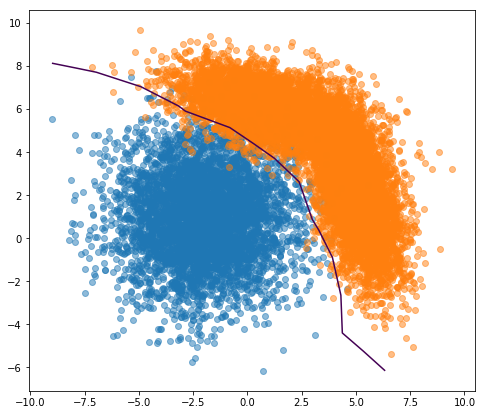

Test score : 0.05082153688768546
Test accuracy : 0.9829999999682109
param : node=10, hidden=10


<Figure size 432x288 with 0 Axes>

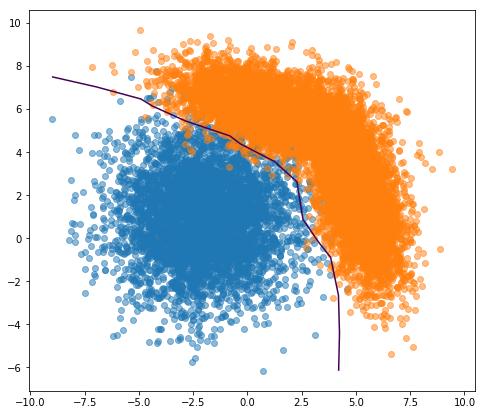

Test score : 0.045084730175696315
Test accuracy : 0.9854666666348775
param : node=20, hidden=20


<Figure size 432x288 with 0 Axes>

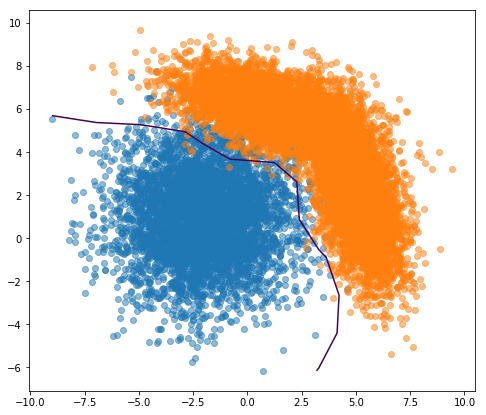

Test score : 0.0650028640408069
Test accuracy : 0.979


In [12]:
"""" create data """
num = 10000

mean1 = np.array([-2, 1])
mean2 = np.array([5, 2])
mean3 = np.array([1, 6])

cov1 = CovarianceMatrix.compose([2, 2], [0])
cov2 = CovarianceMatrix.compose([1, 2], [-1])
cov3 = CovarianceMatrix.compose([2, 1], [-1])

p1 = [0.5, 0.5]

nomal1 = Nomal.create(vec_m=mean1, mat_cov=cov1, p=p1[0], num=num)
nomal2 = Nomal.create(vec_m=mean2, mat_cov=cov2, p=p1[1], num=num)
nomal3 = Nomal.create(vec_m=mean3, mat_cov=cov3, p=p1[1], num=num)
nomal4 = nomal2.concat(nomal3)

nomal1['target'] = 1
nomal4['target'] = 0

df_sample = pd.concat([nomal1, nomal4])

df_train = df_sample.drop('target', axis=1)
df_label = df_sample['target']

""" run task """
init_param1 = {
    "df_train" : df_train,
    "df_label" : df_label,
    "node_count" : 5, 
    "hidden_count" : 5, 
    "epochs" : 20, 
    "batch_size" : 10
}

init_param2 = {
    "df_train" : df_train,
    "df_label" : df_label,
    "node_count" : 10, 
    "hidden_count" : 10, 
    "epochs" : 20, 
    "batch_size" : 10
}

init_param3 = {
    "df_train" : df_train,
    "df_label" : df_label,
    "node_count" : 20, 
    "hidden_count" : 20, 
    "epochs" : 20, 
    "batch_size" : 10
}

Task(**init_param1).run(verbose=0, is_dev=False)
Task(**init_param2).run(verbose=0, is_dev=False)
Task(**init_param3).run(verbose=0, is_dev=False)

param : node=10, hidden=15


<Figure size 432x288 with 0 Axes>

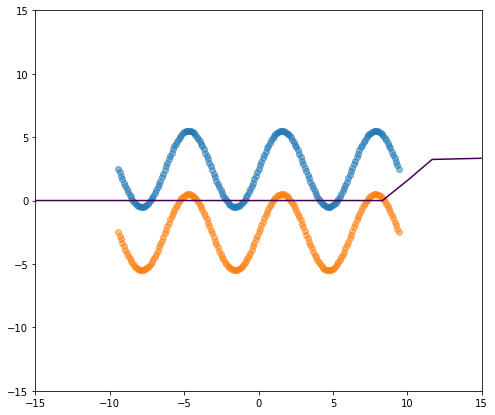

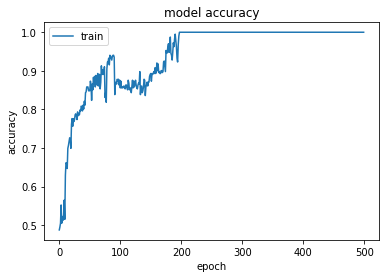

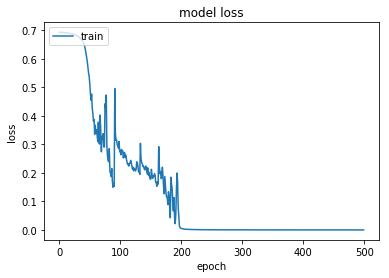

Test score : 7.722127653935681e-05
Test accuracy : 1.0


In [11]:
"""" create data """
x = np.linspace(-3 * np.pi, 3 * np.pi, 201)
sin = np.sin(x)
cos = np.cos(x)

bias = 2.5

df_c1 = pd.DataFrame(np.vstack((x, 3 * sin - bias)).T)
df_c1['target'] = 0
df_c2 = pd.DataFrame(np.vstack((x, 3 * sin + bias)).T)
df_c2['target'] = 1
df_sample = pd.concat((df_c1, df_c2))

df_sample.head()

df_train = df_sample.drop('target', axis=1)
df_label = df_sample['target']

""" run task """
init_param = {
    "df_train" : df_train,
    "df_label" : df_label,
    "node_count" : 10, 
    "hidden_count" : 15, 
    "epochs" : 500, 
    "batch_size" : 50
}

num = 15
ranges = [(-num, num), (-num, num)]

Task(**init_param).run(ranges, verbose=0)